In [4]:
cd /home/chenxupeng/projects/deepshape

/home/chenxupeng/projects/deepshape


In [26]:
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping,TensorBoard,ModelCheckpoint
from keras.optimizers import Adam
import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import multiply,Merge,Input,Conv1D,  Conv2D, MaxPooling1D,MaxPooling2D, UpSampling2D,Lambda, Dot,average,add, concatenate,GlobalMaxPooling1D, GlobalMaxPooling2D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers.merge import Concatenate, Add
from keras.initializers import RandomNormal
from keras.regularizers import l2, l1, l1_l2
from keras.layers.wrappers import Bidirectional
from keras.layers.recurrent import LSTM
from functools import partial
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.99
config.gpu_options.allow_growth =True
set_session(tf.Session(config=config))

In [3]:
import argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import h5py
import os
from tqdm import tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('bin')

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['average', 'add', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


peaks.transcript_coord.extended.fa
peaks.icshape.Lu_2016_invitro
peaks.icshape.Lu_2016_invivo
peaks.bed  

In [ ]:
icshape = {}
with h5py.File('1_PARCLIP_AGO1234_hg19/30000/training_sample_0/peaks.icshape.Lu_2016_invitro', 'r') as fin:
    for key in fin.keys():
        icshape[key] = fin[key][:]

In [ ]:
def get_icshape(bed_file,icshape_file,output_file):
    import numpy as np
    import h5py
    import pandas as pd
    from tqdm import tqdm
    from genomic_data import GenomicData

    bed = pd.read_table(bed_file, header=None)

    icshape = {}
    with h5py.File(icshape_file, 'r') as fin:
        for key in fin.keys():
            icshape[key] = fin[key][:]

    logger.info('create output file: ')
    if not os.path.exists(output_file):
        fout = h5py.File(output_file, 'w')
        for row in tqdm(bed.itertuples(index=False), total=bed.shape[0]):
            transcript_id = row[0]
            peak_id =str(row[3])
            data = icshape.get(transcript_id)
            if data is not None:
                fout.create_dataset('%s,%s,%d,%d'%(peak_id, transcript_id, row[1], row[2]), data=data[row[1]:row[2]])
        fout.close()
def create_dataset(args):
    import numpy as np
    import h5py
    import pandas as pd
    from tqdm import tqdm
    from formats import read_fasta

    logger.info('read peak file: ' + args.peak_file)
    peaks = pd.read_table(args.peak_file,
        names=['chrom', 'start', 'end', 'peak_id', 'label', 'strand'])
    peaks['peak_id'] = peaks['peak_id'].astype('U')
    peaks.index = peaks['peak_id']
    logger.info('read sequence file: ' + args.sequence_file)
    sequences = {name:seq for name, seq in read_fasta(args.sequence_file)}
    logger.info('read reactivity file: ' + args.reactivity_file)
    reactivities = {}
    with h5py.File(args.reactivity_file, 'r') as f:
        for peak_id in f.keys():
            reactivities[peak_id.split(',')[0]] = f[peak_id][:]
    peak_ids = list(sorted(reactivities.keys()))

    def onehot_encode(x, alphabet='ATCG'):
        alphabet = np.frombuffer(bytearray(alphabet, encoding='ascii'), dtype='S1')
        x_shape = list(x.shape)
        encoded = (x.reshape(x_shape + [1]) == alphabet.reshape([1]*len(x_shape) + [-1])).astype(np.int32)
        return encoded

    X_seq = np.concatenate([np.frombuffer(bytearray(sequences[peak_id], encoding='ascii'), dtype='S1')[np.newaxis, :] for peak_id in peak_ids], axis=0)
    X_seq = onehot_encode(X_seq)
    X_r   = np.concatenate([reactivities[peak_id][np.newaxis, :, np.newaxis] for peak_id in peak_ids], axis=0)
    # imputate reactivities with median values
    X_r[np.isnan(X_r)] = np.nanmedian(X_r.flatten())
    X = np.concatenate([X_seq, X_r], axis=2)
    y = peaks['label'][peak_ids]
    logger.info('create output file: ' + args.output_file)
    with h5py.File(args.output_file, 'w') as fout:
        fout.create_dataset('X', data=X)
        fout.create_dataset('y', data=y)

In [ ]:
def summarize_metrics(args):
    import numpy as np
    import h5py
    import pandas as pd
    from tqdm import tqdm
    from ioutils import open_file_or_stdout

    def parse_filename(filename):
        c = filename.split('/')
        d = {'dataset': c[2],
            'cv_index': c[4].split('_')[-1],
            'model_name': c[-1].split('.')[1],
            'icshape_dataset': c[-1].split('.')[2]
        }
        return d

    summary = []
    for input_file in args.input_files:
        d = parse_filename(input_file)
        with h5py.File(input_file, 'r') as f:
            d['accuracy'] = f['metrics/accuracy'][()]
            d['roc_auc'] = f['metrics/roc_auc'][()]
            summary.append(d)
    summary = pd.DataFrame.from_records(summary)
    summary = summary[['dataset', 'icshape_dataset', 'model_name', 'cv_index', 'accuracy', 'roc_auc']]
    with open_file_or_stdout(args.output_file) as fout:
        summary.to_csv(fout, sep='\t', index=False)

In [7]:
output_dir = 'output/motif_ionmf'
datasets =  ["10_PARCLIP_ELAVL1A_hg19", "11_CLIPSEQ_ELAVL1_hg19","12_PARCLIP_EWSR1_hg19",
        "13_PARCLIP_FUS_hg19","14_PARCLIP_FUS_mut_hg19","15_PARCLIP_IGF2BP123_hg19",
        "1_PARCLIP_AGO1234_hg19","21_PARCLIP_MOV10_Sievers_hg19",
        "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome",
        "23_PARCLIP_PUM2_hg19","24_PARCLIP_QKI_hg19","25_CLIPSEQ_SFRS1_hg19",
        "26_PARCLIP_TAF15_hg19","2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters",
        "4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19","8_PARCLIP_ELAVL1_hg19",
        "9_PARCLIP_ELAVL1MNASE_hg19"]
n_samples = '30000'
subset = ["training_sample_0","training_sample_1","training_sample_2",
        "test_sample_0","test_sample_1","test_sample_2"]
training_sets= ["training_sample_0","training_sample_1","training_sample_2"]
test_sets =  ["test_sample_0","test_sample_1","test_sample_2"]
training_sample ={"test_sample_0": "training_sample_0","test_sample_1": "training_sample_1",
"test_sample_2": "training_sample_2"}
annotation = "gencode.v19"
ionmf_data_dir = "home/chenxupeng/projects/deepshape/clip"
icshape_datasets = ["Lu_2016_invitro", "Lu_2016_invivo"]
features = ['observed_reactivity','seq_only']

In [8]:
def get_icshape_data(datasetind,subsetind,icshapedatasetind,featureind):
    return 'output/motif_ionmf'+'/'+datasets[datasetind]+'/'+n_samples+'/'+\
training_sets[subsetind]+'/'+'dataset.'+icshape_datasets[icshapedatasetind]+'.'+features[featureind]

# prepare dataset

## sequence data

In [ ]:
get_icshape_data(0,0,0,1) #[19,3,2,2]
with h5py.File(get_icshape_data(0,0,0,1)) as f:
    sequences = f['X'][:]
    label = f['y'][:]

## icshape data &seq data

In [9]:
#[19,3,2,2]
with h5py.File(get_icshape_data(0,0,0,0)) as f:
    train_X = f['X'][:]
    train_y = f['y'][:]

In [13]:
train_X[0,:,-1][1]

0.0949999988079071

# merge layer to connect weight data with input
weight layer single channel

In [63]:
def tf_window_function(x, c, w, t):
    return tf.where(x <= c, 
                    tf.sigmoid(t*(x - (c - 0.5*w))),
                    tf.sigmoid(t*(-x + (c + 0.5*w))))

In [59]:
def merge_model(window_size, n_channels=5, weight_channels =1,regression=False, dense=False):
    A1 = keras.layers.Input(shape=(window_size,n_channels),name='A1')
    A2 = Conv1D(window_size, 7, padding='valid',kernel_regularizer=l2(0.0001),name="A2")(A1)
    A3 = Activation('relu',name="A3")(A2)
    A4 = MaxPooling1D(2,name="A4")(A3)
    A5 = Conv1D(window_size, 3, padding='valid', kernel_regularizer=l2(0.0001),name="A5")(A4)
    A6 = Activation('relu',name="A6")(A5)
    A7 = MaxPooling1D(2,name="A7")(A6)
    A8 = Conv1D(window_size, 3, padding='valid', kernel_regularizer=l2(0.0001),name="A8")(A7)
    A9 = Activation('relu',name="A9")(A8)
    A10 = MaxPooling1D(2,name="A10")(A9)
    A11 = Flatten(name="A11")(A10)
    A12 = Dense(window_size, kernel_regularizer=l2(0.0001),name="A12")(A11)
    A13 = Activation('relu',name="A13")(A12)
    
    B2 = Conv1D(window_size, 7, padding='valid',kernel_regularizer=l2(0.0001),name="B2")(A1)
    B3 = Activation('relu',name="B3")(B2)
    B4 = MaxPooling1D(2,name="B4")(B3)
    B5 = Conv1D(window_size, 3, padding='valid', kernel_regularizer=l2(0.0001),name="B5")(B4)
    B6 = Activation('relu',name="B6")(B5)
    B7 = MaxPooling1D(2,name="B7")(B6)
    B8 = Conv1D(window_size, 3, padding='valid', kernel_regularizer=l2(0.0001),name="B8")(B7)
    B9 = Activation('relu',name="B9")(B8)
    B10 = MaxPooling1D(2,name="B10")(B9)
    B11 = Flatten(name="B11")(B10)
    B12 = Dense(window_size, kernel_regularizer=l2(0.0001),name="B12")(B11)
    B13 = Activation('relu',name="B13")(B12)
    B14 = Dense(3, kernel_regularizer=l2(0.0001),name="B14")(B13)
    B15 = Activation('relu',name="B15")(B14)
    
    rangenum = tf.cast(K.arange(1,101), tf.float32)
    funcwindow =Lambda(lambda x: tf_window_function(rangenum,x[0],x[1],x[2]),\
                       output_shape=(window_size,),name='functionwindow')(B15)
    
    output_size = window_size if dense else 1 
    multiple = multiply([A13, funcwindow])
    if not regression:
        out = Dense(output_size,init = 'normal',activation ='sigmoid',name='out')(multiple)
    model = Model(inputs=[A1], outputs=[out])
    return model

In [62]:
rangenum = tf.cast(K.arange(1,101), tf.float32)
x = tf.cast(tf.Variable([3,2,4]), tf.float32)
tf_window_function(rangenum,x[0],x[1],x[2])

<tf.Tensor 'Select_1:0' shape=(100,) dtype=float32>

In [60]:
model = merge_model(100)
loss = 'binary_crossentropy'
metrics = ['accuracy']
model.compile(optimizer='Adam',loss=loss,metrics=metrics)
model.summary()

ValueError: Dimensions must be equal, but are 100 and 3 for 'functionwindow_4/LessEqual' (op: 'LessEqual') with input shapes: [100], [3].

## visualize model

####  训练模型学会三个参数，获得窗口函数
假设，只有一个峰，如果有两个？

In [46]:
x.shape

(1000,)

In [44]:
window_function(x, c=5, w=2, t=10)

array([4.24835426e-18, 4.69562758e-18, 5.18999054e-18, 5.73640079e-18,
       6.34033797e-18, 7.00785859e-18, 7.74565681e-18, 8.56113157e-18,
       9.46246079e-18, 1.04586833e-17, 1.15597897e-17, 1.27768223e-17,
       1.41219860e-17, 1.56087706e-17, 1.72520862e-17, 1.90684126e-17,
       2.10759647e-17, 2.32948749e-17, 2.57473955e-17, 2.84581212e-17,
       3.14542364e-17, 3.47657872e-17, 3.84259832e-17, 4.24715303e-17,
       4.69429989e-17, 5.18852306e-17, 5.73477882e-17, 6.33854523e-17,
       7.00587711e-17, 7.74346672e-17, 8.55871091e-17, 9.45978527e-17,
       1.04557261e-16, 1.15565212e-16, 1.27732097e-16, 1.41179930e-16,
       1.56043572e-16, 1.72472082e-16, 1.90630210e-16, 2.10700054e-16,
       2.32882883e-16, 2.57401154e-16, 2.84500747e-16, 3.14453427e-16,
       3.47559571e-16, 3.84151182e-16, 4.24595214e-16, 4.69297257e-16,
       5.18705601e-16, 5.73315731e-16, 6.33675300e-16, 7.00389619e-16,
       7.74127725e-16, 8.55629093e-16, 9.45711051e-16, 1.04527698e-15,
      

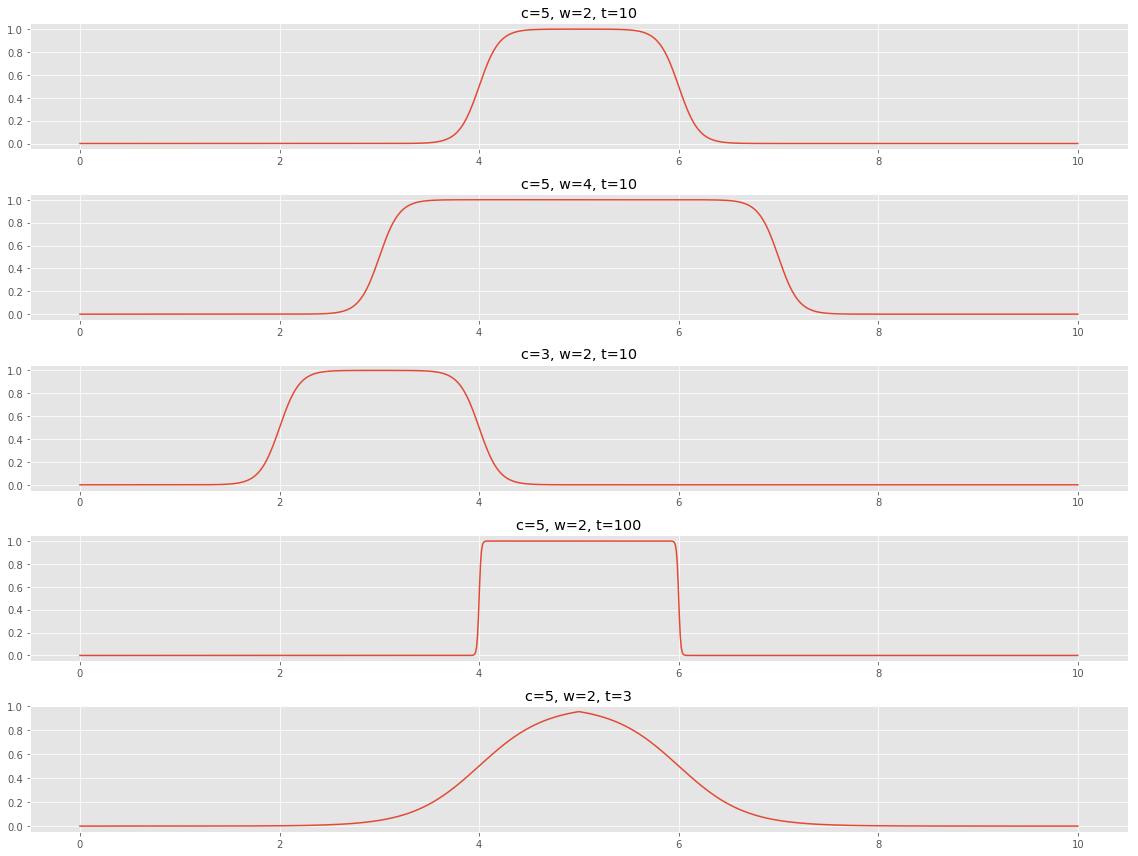

In [43]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def window_function(x, c, w, t=1):
    return np.where(x <= c, 
                    sigmoid(t*(x - (c - 0.5*w))),
                    sigmoid(t*(-x + (c + 0.5*w))))

x = np.linspace(0, 10, 1000)
y = window_function(x, c=5, w=2, t=10)
fig, axes = plt.subplots(5, 1, figsize=(16, 12))
axes[0].plot(x, window_function(x, c=5, w=2, t=10))
axes[0].set_title('c=5, w=2, t=10')
axes[1].plot(x, window_function(x, c=5, w=4, t=10))
axes[1].set_title('c=5, w=4, t=10')
axes[2].plot(x, window_function(x, c=3, w=2, t=10))
axes[2].set_title('c=3, w=2, t=10')
axes[3].plot(x, window_function(x, c=5, w=2, t=100))
axes[3].set_title('c=5, w=2, t=100')
axes[4].plot(x, window_function(x, c=5, w=2, t=3))
axes[4].set_title('c=5, w=2, t=3')
plt.tight_layout()

### 获取model的train之后的weight